In [11]:
!pip install -q kaggle

# Upload kaggle.json
from google.colab import files
files.upload()  # upload your kaggle.json file here

# Create kaggle directory and move the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [12]:
!kaggle datasets download -d omkargurav/face-mask-dataset
!unzip -q face-mask-dataset.zip -d face-mask-dataset


Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown


In [69]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam



In [17]:
base_dir = "/content/face-mask-dataset/data"

train_dir = os.path.join(base_dir, "Train")
val_dir = os.path.join(base_dir, "Validation")
test_dir = os.path.join(base_dir, "Test")


In [16]:
!ls /content/face-mask-dataset


data


In [19]:
!ls /content/face-mask-dataset/data


with_mask  without_mask


In [20]:
import os
import shutil

# Directories to create
base_dir = "/content/face-mask-dataset/data"
train_dir = "/content/face-mask-dataset/train"
val_dir = "/content/face-mask-dataset/val"
test_dir = "/content/face-mask-dataset/test"

# Create the directories
for dir in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(dir, 'with_mask'), exist_ok=True)
    os.makedirs(os.path.join(dir, 'without_mask'), exist_ok=True)

# Move the data into appropriate directories
def split_data(source_dir, dest_dir, split_ratio=0.8):
    for category in ['with_mask', 'without_mask']:
        category_path = os.path.join(source_dir, category)
        images = os.listdir(category_path)
        num_images = len(images)

        # Shuffle and split
        np.random.shuffle(images)
        split_idx_train = int(split_ratio * num_images)
        split_idx_val = int((split_ratio + (1-split_ratio)/2) * num_images)

        # Move files
        for i, image in enumerate(images):
            source = os.path.join(category_path, image)
            if i < split_idx_train:
                dest = os.path.join(dest_dir, 'train', category, image)
            elif i < split_idx_val:
                dest = os.path.join(dest_dir, 'val', category, image)
            else:
                dest = os.path.join(dest_dir, 'test', category, image)
            shutil.copy(source, dest)

# Perform the split
split_data(base_dir, "/content/face-mask-dataset")




In [21]:
print("Train data:", os.listdir(train_dir))
print("Validation data:", os.listdir(val_dir))
print("Test data:", os.listdir(test_dir))



Train data: ['with_mask', 'without_mask']
Validation data: ['with_mask', 'without_mask']
Test data: ['with_mask', 'without_mask']


In [23]:
# Directories
train_dir = "/content/face-mask-dataset/train"
val_dir = "/content/face-mask-dataset/val"
test_dir = "/content/face-mask-dataset/test"



In [24]:
# Image size and batch size
img_size = 128
batch_size = 32

# Data augmentation for training data
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.2,
                                   shear_range=0.2, horizontal_flip=True)

# Rescale for validation and test data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load the datasets
train_data = train_datagen.flow_from_directory(train_dir, target_size=(img_size, img_size),
                                               batch_size=batch_size, class_mode='binary')

val_data = val_test_datagen.flow_from_directory(val_dir, target_size=(img_size, img_size),
                                                batch_size=batch_size, class_mode='binary')

test_data = val_test_datagen.flow_from_directory(test_dir, target_size=(img_size, img_size),
                                                 batch_size=batch_size, class_mode='binary',
                                                 shuffle=False)


Found 6042 images belonging to 2 classes.
Found 755 images belonging to 2 classes.
Found 756 images belonging to 2 classes.


In [25]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [27]:

history = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 39/189 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - accuracy: 0.5617 - loss: 0.6726

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 42s 192ms/step - accuracy: 0.7106 - loss: 0.5398 - val_accuracy: 0.8874 - val_loss: 0.2968
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 32s 169ms/step - accuracy: 0.8823 - loss: 0.2979 - val_accuracy: 0.8980 - val_loss: 0.2648
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 33s 173ms/step - accuracy: 0.8913 - loss: 0.2772 - val_accuracy: 0.9007 - val_loss: 0.2456
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 33s 173ms/step - accuracy: 0.8950 - loss: 0.2673 - val_accuracy: 0.9033 - val_loss: 0.2267
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 32s 168ms/step - accuracy: 0.9026 - loss: 0.2488 - val_accuracy: 0.9033 - val_loss: 0.2357
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 32s 171ms/step - accuracy: 0.9043 - loss: 0.2309 - val_accuracy: 0.9139 - val_loss: 0.2228
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 32s 171ms/step - accuracy: 0.9050 - loss: 0.2369 - val_accuracy: 0.9219 - val_loss: 0.2020
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 32s 169ms/step - accuracy: 0.9103 - loss: 0.2197 - val

In [28]:
test_loss, test_acc = model.evaluate(test_data)
print("Test Accuracy:", test_acc)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9395 - loss: 0.1585
Test Accuracy: 0.929894208908081


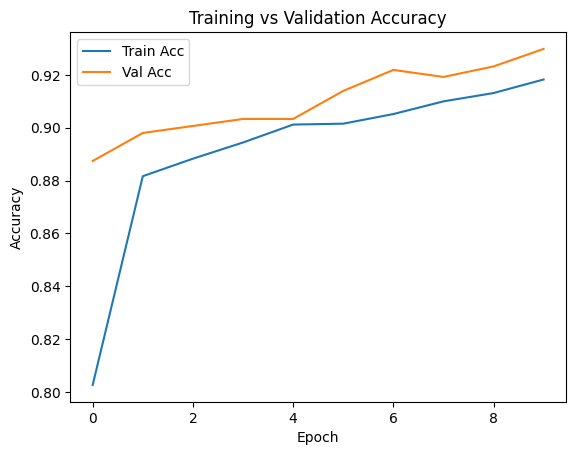

In [29]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


In [71]:
# Save the trained model
# Save the trained model in the native Keras format
model.save('face_mask_detection_model.keras')



In [38]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = keras.models.load_model('face_mask_detection_model.keras')

# Load a new image for prediction
img_path = '/content/face-mask-3.jpg'  # Update this to your test image path
img = image.load_img(img_path, target_size=(img_size, img_size))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict if the image is with or without mask
prediction = model.predict(img_array)
print("Prediction (0 = with mask, 1 = without mask):", prediction[0][0])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
Prediction (0 = with mask, 1 = without mask): 0.5782863


In [41]:
img_path = '/content/face-mask-3.jpg'  # Update with your uploaded image's correct path


In [42]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = keras.models.load_model('face_mask_detection_model.keras')

# Set the image size to match what was used during training
img_size = 128  # Make sure this matches the input size during training

# Load the new image for prediction
img_path = '/content/face-mask-3.jpg'  # Update with the correct image path
img = image.load_img(img_path, target_size=(img_size, img_size))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict if the image is with or without mask
prediction = model.predict(img_array)
print("Prediction (0 = with mask, 1 = without mask):", prediction[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Prediction (0 = with mask, 1 = without mask): 0.5782863


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


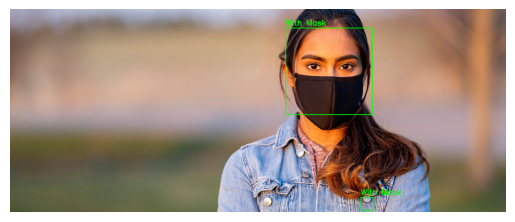

In [68]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the saved model
model = keras.models.load_model('face_mask_detection_model.keras')

# Set the image size to match what was used during training
img_size = 128  # Make sure this matches the input size during training

# Load the image for prediction
img_path = '/content/mask myths.jpg'  # Update with the correct image path
img = image.load_img(img_path, target_size=(img_size, img_size))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict if the image is with or without mask
prediction = model.predict(img_array)
prediction_label = 'With Mask' if prediction[0][0] < 0.5 else 'Without Mask'

# Load the image with OpenCV for face detection
img_cv = cv2.imread(img_path)

# Convert to grayscale for face detection
gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)

# Load the pre-trained Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around the faces and annotate with prediction
for (x, y, w, h) in faces:
    # Draw rectangle around face
    cv2.rectangle(img_cv, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # Put prediction text near the face
    cv2.putText(img_cv, prediction_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0) if prediction_label == 'With Mask' else (0, 0, 255), 2, cv2.LINE_AA)

# Convert the BGR image (OpenCV format) to RGB for displaying in matplotlib
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# Show the image with face bounding boxes and prediction labels
plt.imshow(img_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


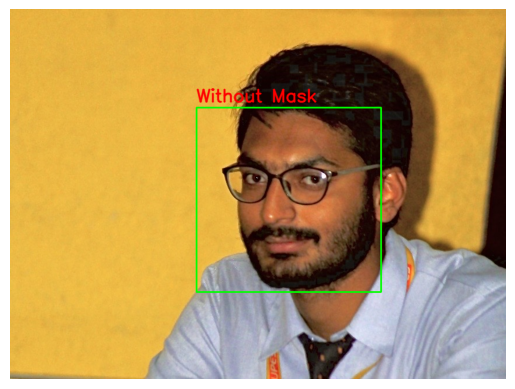

In [64]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the saved model
model = keras.models.load_model('face_mask_detection_model.keras')

# Set the image size to match what was used during training
img_size = 128  # Make sure this matches the input size during training

# Load the image for prediction
img_path = '/content/face-mask-3.jpg'  # Update with the correct image path
img = image.load_img(img_path, target_size=(img_size, img_size))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict if the image is with or without mask
prediction = model.predict(img_array)
prediction_label = 'With Mask' if prediction[0][0] < 0.5 else 'Without Mask'

# Load the image with OpenCV for face detection
img_cv = cv2.imread(img_path)

# Convert to grayscale for face detection
gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)

# Load the pre-trained Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around the faces and annotate with prediction
for (x, y, w, h) in faces:
    # Draw rectangle around face
    cv2.rectangle(img_cv, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # Put prediction text near the face
    cv2.putText(img_cv, prediction_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0) if prediction_label == 'With Mask' else (0, 0, 255), 2, cv2.LINE_AA)

# Convert the BGR image (OpenCV format) to RGB for displaying in matplotlib
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# Show the image with face bounding boxes and prediction labels
plt.imshow(img_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()


In [55]:
pip install opencv-python
